In [0]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from scipy.linalg import inv


def f0(t,Q,v,b,A,p):
  tmp = [np.log(b[i] - np.dot(A[i,:],v)) for i in range(A.shape[0]) ]
  return t*(np.dot(v.T,np.dot(Q,v))) + t*np.dot(p.T, v) - np.sum(tmp,axis = 0)


def grad_f0(t,Q,v,p,A,b):
  tmp = [A[i,:] / (b[i] - np.dot(A[i,:], v ) ) for i in range(A.shape[0])]
  return np.dot(t*(Q + Q.T), v).reshape(-1,1) + (p*t).reshape(-1,1) + np.sum(tmp, axis = 0).reshape(-1,1)

def Hessian_f0(A,t,Q,b,v):
  tmp = [ ( A[i,:].reshape((A.shape[1],1))@A[i,:].T.reshape((1,A.shape[1])) ) / (b[i] - np.dot(A[i,:].T, v ) )**2 for i in range(A.shape[0])]
  return t*(Q + Q.T) + np.sum(tmp,axis = 0)

def centering_step(t,Q,v0,p,A,b,eps):
  """ This function is meant to compute the inner steps, i.e. the Newton's method for an unconstrained optimization problem"""
  V = []
  V.append(v0)
  ## Newton part :
  v = v0
  while(True):
    tmp_gradf0 = grad_f0(t,Q,v,p,A,b) 
    tmp_Hess_f0 = Hessian_f0(A,t,Q,b,v)
    inv_Hess = inv(tmp_Hess_f0)

    newton_step = -np.dot(inv_Hess, tmp_gradf0)
    lambda_squared = np.dot(np.dot(tmp_gradf0.T,inv_Hess ), tmp_gradf0)
    stopping_crit = lambda_squared/2
    if (stopping_crit <= eps):
      break
    else : 
      ## Backtracking line search, alpha in (0,0.5) and beta in (0,1) 
      alpha, beta =  0.05, 0.45
      t_linesearch = 1
      while( not((b-np.dot(A,v+t_linesearch*newton_step))>0).all() or f0(t,Q,v + t_linesearch*newton_step,b,A,p) > f0(t,Q,v,b,A,p) + alpha*t_linesearch * (np.dot(grad_f0(t,Q,v,p,A,b).T, newton_step)) ):
        t_linesearch = beta*t_linesearch
      v = v + t_linesearch*newton_step
      V.append(v)
  return V

def barr_method(Q,p,A,b,v0,eps,mu):
  """ This function computes a central path to the QP optimization problem"""
 
  t = 0.5
  v = v0
  V = [v0]
  m = A.shape[0]
  
  nbr_newt_iter = [0] ## Added for the final plot, contains the number of inner steps (in Newton's method)
  while(True):
      tmp = centering_step(t,Q,v,p,A,b,eps)
      v = tmp[-1]
      #print("v : {}".format(v))
      nbr_newt_iter.append(len(tmp))
      V.append(v)
      if (m/t < eps):
        break
      else :
        t = mu*t

  return nbr_newt_iter, V

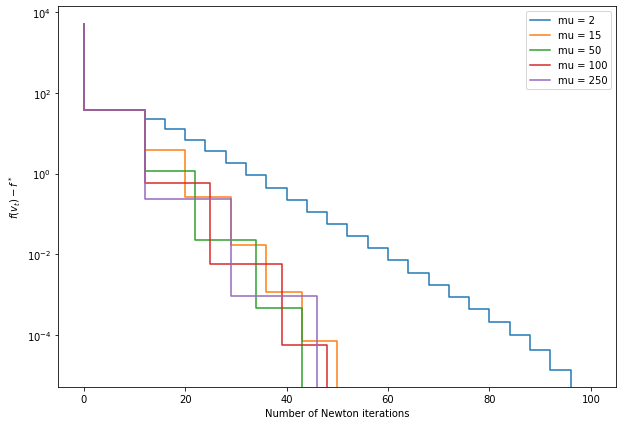

In [38]:
import sklearn
from sklearn.datasets import make_regression
## Test on LASSO ##
d = 100
n = 50

# Initial LASSO paramaters 
lbda = 10
np.random.seed(2)
X,y = make_regression(n_samples=n, n_features=d, n_informative=10, noise = 1)
y = y.reshape((-1,1))

# QP parameters 
Q = 1/2* np.eye(n)
b = np.zeros(2*d) + lbda
A = np.concatenate((X.T, -X.T), axis = 0)
p = -y
# Barrier method parameters

mu_list = [2,15,50,100,250]
eps = 0.0001

# Feasible point 
v0 =np.zeros(n).reshape(-1,1) # since lambda > 0, it is always a feasible point (bi = lambda)

results = [] # contains central points for each mu
newt_steps_recap = [] # contains number of newton steps per outer iteration for each mu
for mu in mu_list : 
  ## We added mu as an argument of barr_method for simplicity
  newt_itr, minimizers_values = barr_method(Q,p,A,b,v0,eps,mu)
  results.append(minimizers_values)
  newt_steps_recap.append(newt_itr)


## List of vector of differences wrt to surrogate f*
vec = [[l[i].T@Q@l[i] + np.dot(p.reshape((1,-1)),l[i]) - l[-1].T@Q@l[-1] - np.dot(p.reshape((1,-1)),l[-1]) for i in range(len(l))] for l in results]

## Plotting 
plt.figure(figsize=(10,7))  
for i in range(len(results)):
  t = np.cumsum(newt_steps_recap[i]).reshape(-1,1)
  plt.step(t, np.ravel(vec[i]), label = "mu = {}".format(str(mu_list[i])))
  plt.legend(loc = 'upper right')

plt.semilogy()
plt.xlabel('Number of Newton iterations')
plt.ylabel('$f(v_t)-f^*$')
plt.show()